# Import Library & Dataset

In [1]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.tag import pos_tag
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [3]:
url = "https://drive.google.com/uc?export=download&id=137HNRlOaC_3W89lPmfNBy0sTSSlAjfH-"
df = pd.read_csv(url)

# Exploratory Data Analysis

Melihat contoh data yang ada di dalam dataset Mental Health Corpus.

In [4]:
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


Menampilkan dimensi DataFrame dalam bentuk (jumlah_baris, jumlah_kolom).

In [5]:
df.shape

(27977, 2)

Melihat ringkasan informasi tentang DataFrame df, yaitu: jumlah baris, jumlah kolom, tipe data setiap kolom, dan jumlah nilai non-null.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB


Mengecek missing value pada setiap kolom di DataFrame.

In [7]:
df.isnull().sum()

,0
text,0
label,0


Melihat jumlah data pada label 0 dan 1.

In [8]:
df.label.value_counts()

,count
label,
0,14139
1,13838


Memvisualisasikan distribusi data label 0 dan 1 dengan diagram batang (jumlah kemunculan) dan diagram lingkaran (persentase).

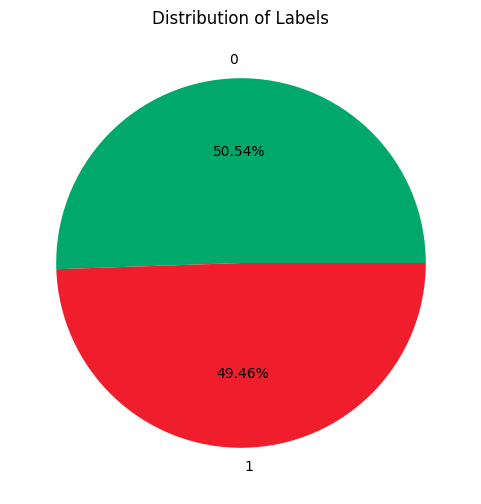

In [9]:
label_counts = df['label'].value_counts()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.2f%%', colors=['#00A86B', '#F01E2C'])
plt.title('Distribution of Labels')
plt.show()

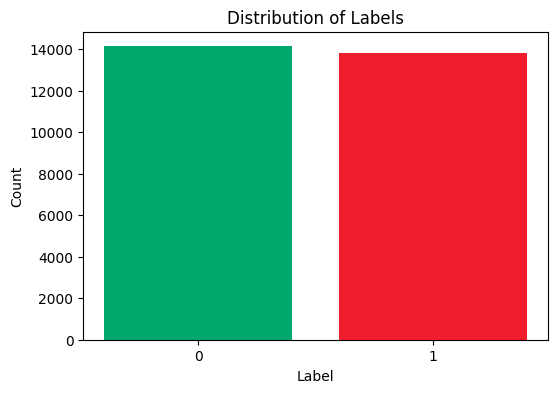

In [10]:
# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['#00A86B', '#F01E2C'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(label_counts.index)  # Ensure x-axis ticks match the labels
plt.show()

Menampilkan pola visual dari kata-kata yang sering muncul dengan word cloud sebelum data di*pre-process*.

In [11]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

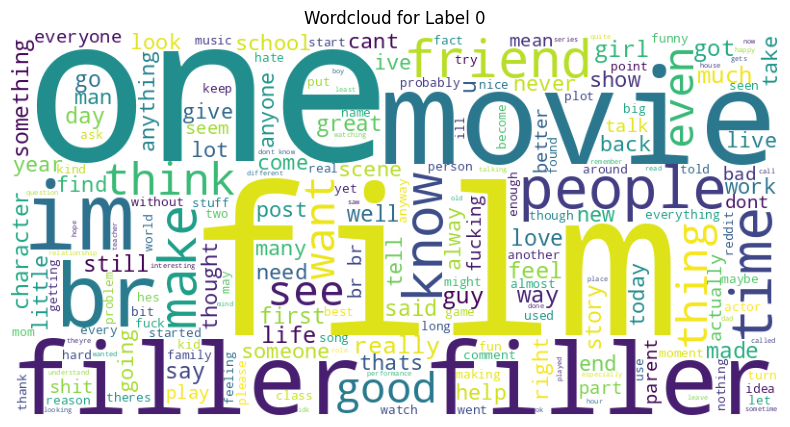

In [12]:
text_label_0 = " ".join(df[df['label'] == 0]['text'].astype(str))
plot_wordcloud(text_label_0, "Wordcloud for Label 0")

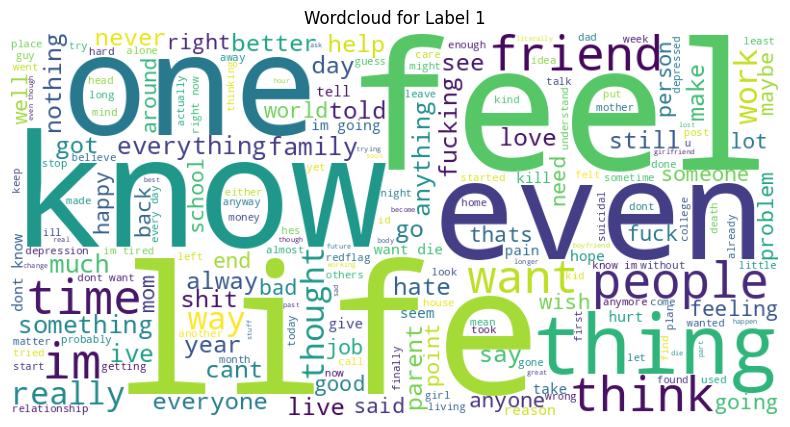

In [13]:
text_label_1 = " ".join(df[df['label'] == 1]['text'].astype(str))
plot_wordcloud(text_label_1, "Wordcloud for Label 1")

 Menunjukkan frekuensi kata yang paling banyak muncul berdasarkan label sebelum data di*pre-process*.

In [14]:
def count_words(df):
    word_counts_label_0 = {}
    word_counts_label_1 = {}

    for index, row in df.iterrows():
        text = row['text']
        label = row['label']
        words = word_tokenize(text)

        for word in words:
            word = word.lower()
            if label == 0:
                word_counts_label_0[word] = word_counts_label_0.get(word, 0) + 1
            elif label == 1:
                word_counts_label_1[word] = word_counts_label_1.get(word, 0) + 1

    df_label_0 = pd.DataFrame({'Word': list(word_counts_label_0.keys()), 'Count': list(word_counts_label_0.values())})
    df_label_1 = pd.DataFrame({'Word': list(word_counts_label_1.keys()), 'Count': list(word_counts_label_1.values())})

    df_label_0 = df_label_0.sort_values(by='Count', ascending=False)
    df_label_1 = df_label_1.sort_values(by='Count', ascending=False)

    return df_label_0, df_label_1

In [15]:
df_label_0, df_label_1 = count_words(df)

print("Top Word List for Label 0:\n", df_label_0)

Top Word List for Label 0:
                  Word  Count
18               like   6780
23                 im   6676
206                br   5608
110               one   4548
182              film   3880
...               ...    ...
48987        newsroom      1
48988          chezit      1
48989        chezthem      1
48990  motherdaughter      1
48992           romps      1

[49018 rows x 2 columns]


In [16]:
print("Top Word List for Label 1:\n", df_label_1)

Top Word List for Label 1:
                 Word  Count
18                im  28044
10              like  15520
15              want  14944
34              life  12669
9               feel  12660
...              ...    ...
42102   individualit      1
42103      testement      1
42104          wolrd      1
42105  oversaturated      1
42106       communal      1

[42126 rows x 2 columns]


**Kesimpulan EDA:**
1. Dataset memiliki 27.977 baris (entri data) dan 2 kolom, terdiri dari 1 fitur teks ("text") dan 1 label klasifikasi ("label").
2. Tidak terdapat missing values di dalam dataset, sehingga tidak perlu melakukan imputasi data.
3. Distribusi kelas label 0 dan 1 cukup seimbang, yaitu hanya 1.08%. Artinya, dataset tidak mengalami masalah ketidakseimbangan kelas yang signifikan.
4. Label 0 cenderung memiliki kata-kata yang lebih beragam dan berhubungan dengan topik spesifik, seperti film.
5. Label 1 lebih banyak mengandung kata-kata yang terkait dengan emosi, keinginan, dan kehidupan pribadi, menunjukkan kemungkinan teks dalam kategori ini lebih subjektif.
6. Kedua label masih mengandung banyak stopwords yang dapat memengaruhi hasil analisis model jika tidak dilakukan proses filtering.

# Pre-Processing (Data Cleaning)

In [17]:
eng_stopwords = stopwords.words("english")
punctuation_list = string.punctuation
clean_stopwords = {"".join(char for char in word if char not in string.punctuation) for word in eng_stopwords}
stemming = SnowballStemmer("english")
wnl = WordNetLemmatizer()

*   Mengambil daftar stopwords dalam bahasa Inggris dari library NLTK.
*   Menyimpan daftar tanda baca atau symbol dari library string.
*   Membersihkan stopwords dengan menghapus tanda baca yang mungkin menempel pada kata-kata di dalamnya. Hal ini bertujuan untuk mengantisipasi kata seperti im, youre, etc. yang ditulis tanpa menggunakan tanda baca ( ' ).
*   Menggunakan SnowballStemmer bahasa Inggris untuk memotong kata.
*   Menggunakan WordNet Lemmatizer untuk mengembalikan bentuk kata ke bentuk asalnya berdasarkan kamus linguistik.

In [18]:
print(eng_stopwords)
print(clean_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

Membuat masing-masing function untuk pre-process textnya.

In [19]:
def remove_stopwords(word_list):
  return [word for word in word_list if word not in eng_stopwords]

In [20]:
def remove_clean_stopwords(word_list):
  return [word for word in word_list if word not in clean_stopwords]

In [21]:
def remove_punctuation_numbers(word_list):
  return [word for word in word_list if word.isalpha()]

In [22]:
def stemming_word(word_list):
  return [stemming.stem(word) for word in word_list]

In [23]:
def get_tag(tag):
  if tag in ('JJ', 'JJR', 'JJS'):
    return 'a'
  elif tag in ('NN', 'NNS', 'NNP', 'NNPS'):
    return 'n'
  elif tag in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'):
    return 'v'
  elif tag in ('RB', 'RBR', 'RBS'):
    return 'r'
  else:
    return None

In [24]:
def lemmatizing_word(word_list):
  lemma = []
  tagging = pos_tag(word_list)

  for word, tag in tagging:
    label = get_tag(tag.upper())

    if label != None:
      lemma.append(wnl.lemmatize(word, label))
    else:
      lemma.append(wnl.lemmatize(word))

  return lemma

In [25]:
def preprocess_text(text):
  words = word_tokenize(text.lower())
  words = remove_stopwords(words)
  words = remove_clean_stopwords(words)
  words = remove_punctuation_numbers(words)
  words = stemming_word(words)
  words = lemmatizing_word(words)

  return " ".join(words)

**Langkah-langkah *pre-process*:**
1. Mengubah kalimat menjadi token.
2. Menghapus stopwords dari kalimat.
3. Menghapus stopwords tanpa punctuation (symbol) dari kalimat. Contoh: im, dont, youre, etc.
4. Menghapus punctuation dan angka dari kalimat.
5. Melakukan stemming untuk memotong setiap kata dari kalimat ke bentuk dasarnya.
6. Lemmatization bertujuan untuk mengubah setiap kata dalam teks ke bentuk dasarnya berdasarkan kamus linguistik (WordNet). Sebelum dilakukan lemmatization, setiap kata diberikan POS Tagging (Part-of-Speech Tagging) agar bentuk katanya lebih akurat saat diproses oleh WordNetLemmatizer. Lalu, POS tag itu ditranslate menggunakan get_tag(), sehingga sesuai dengan format yang dapat diterima oleh WordNetLemmatizer. Jika POS tag tidak dikenali, kata tetap dilemmatize dalam bentuk default.

In [26]:
clean_texts = []

for text in df["text"].astype(str):
  clean_texts.append(preprocess_text(text))

df["clean_text"] = clean_texts

Bersihkan teks yang ada di dalam dataset dengan menerapkan fungsi preprocess_text() ke setiap teks dalam kolom "text", lalu simpan hasilnya dalam kolom baru, yaitu "clean_text". Lalu, tampilkan hasil sebelum dan sesudah dibersihkan untuk melihat perbedaannya.

In [27]:
df[["text", "clean_text"]].head(100)

,text,clean_text
0,dear american teens question dutch person hear...,dear american teen question dutch person hear ...
1,nothing look forward lifei dont many reasons k...,noth look forward lifei mani reason keep go fe...
2,music recommendations im looking expand playli...,music recommend look expand playlist usual gen...
3,im done trying feel betterthe reason im still ...,do tri feel betterth reason still aliv know mu...
4,worried year old girl subject domestic physic...,worri year old girl subject domest physicalmen...
...,...,...
95,weird or im ambivert already tell pretty weird...,weird ambivert alreadi tell pretti weird scena...
96,weeks ago saved friend redflag suspended reddi...,week ago save friend redflag suspend reddit da...
97,emo anything but songs lonely palaye royal iro...,emo anyth song lone palay royal ironi christop...
98,else dobefore begin long post amp hope take ti...,el dobefor begin long post amp hope take time ...


Cek pola visual dari kata-kata yang sering muncul dengan word cloud setelah dataset dibersihkan.

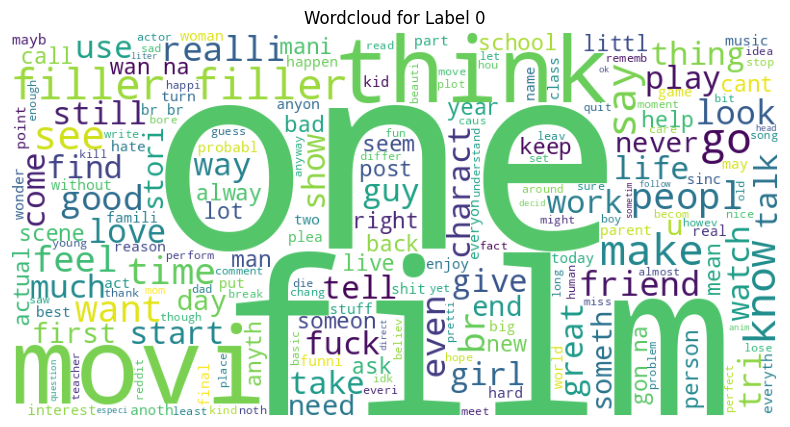

In [28]:
clean_text_label_0 = " ".join(df[df['label'] == 0]['clean_text'].astype(str))
plot_wordcloud(clean_text_label_0, "Wordcloud for Label 0")

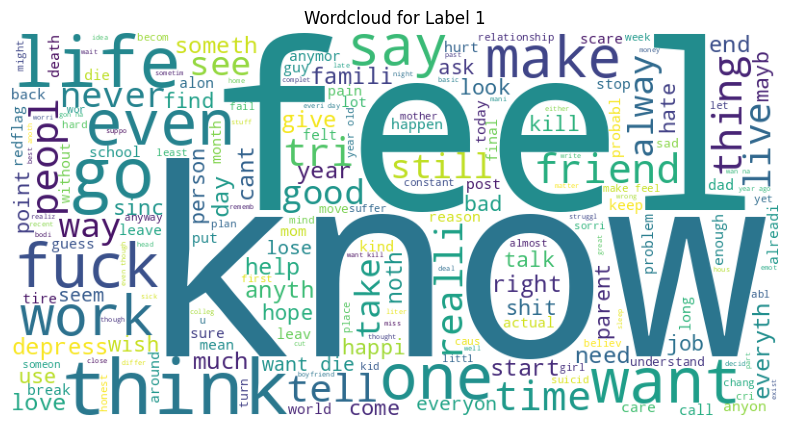

In [29]:
clean_text_label_1 = " ".join(df[df['label'] == 1]['clean_text'].astype(str))
plot_wordcloud(clean_text_label_1, "Wordcloud for Label 1")

Cek frekuensi kata-kata yang ada di dalam dataset setelah dibersihkan.

In [30]:
def count_clean_words(df):
    word_counts_label_0 = {}
    word_counts_label_1 = {}

    for index, row in df.iterrows():
        text = row['clean_text']
        label = row['label']
        words = word_tokenize(text)

        for word in words:
            word = word.lower()
            if label == 0:
                word_counts_label_0[word] = word_counts_label_0.get(word, 0) + 1
            elif label == 1:
                word_counts_label_1[word] = word_counts_label_1.get(word, 0) + 1

    df_label_0 = pd.DataFrame({'Word': list(word_counts_label_0.keys()), 'Count': list(word_counts_label_0.values())})
    df_label_1 = pd.DataFrame({'Word': list(word_counts_label_1.keys()), 'Count': list(word_counts_label_1.values())})

    df_label_0 = df_label_0.sort_values(by='Count', ascending=False)
    df_label_1 = df_label_1.sort_values(by='Count', ascending=False)

    return df_label_0, df_label_1

In [31]:
df_label_0, df_label_1 = count_clean_words(df)

print("Top Word List for Label 0:\n", df_label_0)

Top Word List for Label 0:
            Word  Count
18         like   7453
8           get   6329
177          br   5608
156        film   4849
96          one   4800
...         ...    ...
20465  martywho      1
20462   dankmem      1
20459   felinni      1
20458    pendul      1
20453      defo      1

[35321 rows x 2 columns]


In [32]:
print("Top Word List for Label 1:\n", df_label_1)

Top Word List for Label 1:
             Word  Count
13          want  18580
8           feel  17630
56           get  17507
9           like  16248
7             go  15733
...          ...    ...
30492   longlook      1
30440     herask      1
30441  selfident      1
30442   reappear      1
30443    leftmad      1

[30536 rows x 2 columns]


# Data Splitting

In [33]:
X = df["clean_text"]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train) # 0.125 * 0.8 = 0.1

**Langkah-langkah *data splitting*:**
1. Memisahkan kolom fitur (X) dan kolom label (y).
2. X: Kolom "clean_text" yang berisi teks yang telah dibersihkan, digunakan sebagai fitur (input) untuk model.
3. y: Kolom "label" yang berisi label klasifikasi (0 atau 1), digunakan sebagai target (output) untuk model.
4. Train-test split pertama untuk membagi 80% data untuk training dan 20% data untuk testing.
5. Train-test split kedua untuk membagi lagi data training. 12.5% dari data training akan digunakan untuk validasi. Sehingga perhitungannya menjadi 0.125 * 0.8 = 0.1, maka 10% dari total data awal digunakan untuk validasi. Data training yang tersisa adalah 70%.

**Notes:**
* random_state=42: Untuk memastikan pembagian data yang konsisten setiap kali kode dijalankan.
* stratify=y: Menjaga proporsi distribusi label dalam dataset pelatihan dan pengujian, agar seimbang.

In [34]:
print(f"Train data size: {len(X_train)} ({len(X_train)/len(df)*100:.2f}%)")
print(f"Validation data size: {len(X_val)} ({len(X_val)/len(df)*100:.2f}%)")
print(f"Test data size: {len(X_test)} ({len(X_test)/len(df)*100:.2f}%)")

Train data size: 19583 (70.00%)
Validation data size: 2798 (10.00%)
Test data size: 5596 (20.00%)


* Data training (70%) digunakan untuk melatih model.
* Data validation (10%) digunakan untuk mengukur kinerja model selama pelatihan (untuk tuning hyperparameter).
* Data testing (20%) digunakan untuk menguji model yang sudah dilatih setelah proses pelatihan selesai.

# TF-IDF Vectorization

Menghitung jumlah kata unik yang ada di dalam dataset X_train.

In [35]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
print(len(vectorizer.get_feature_names_out()))

43331


In [36]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

**Langkah-langkah TF-IDF Vectorization:**
* Mengubah teks menjadi representasi numerik dengan mempertimbangkan frekuensi kata dalam dokumen (TF) dan seberapa unik kata tersebut di seluruh dokumen (IDF). Max_features yang digunakan adalah 5000 untuk menghindari dimensi yang terlalu besar (Curse of Dimensionality), mencegah overfitting, dan meningkatkan efisiensi komputasi. Fitur yang diambil adalah kata-kata yang paling sering muncul, sehingga tetap representatif terhadap dataset.
* Memproses teks X_train, menghitung skor TF-IDF, dan mengubahnya menjadi matriks numerik.
* Mengubah data validasi (X_val) dan data testing (X_test) menggunakan model yang sudah dilatih dari X_train, agar skala fitur tetap konsisten.

**Notes:**

Saya lebih memilih vectorizer TF-IDF karena dapat menyederhanakan representasi teks secara efisien untuk tugas klasifikasi. TF-IDF cocok dengan model ensemble seperti SVM, Naïve Bayes, dan XGBoost yang akan saya gunakan, karena menghasilkan matriks sparse yang lebih ringan diproses oleh algoritma-algoritma tersebut. Berbeda dengan word embedding (misalnya Word2Vec) yang memerlukan pelatihan model tambahan dan menghasilkan vektor dense yang kompleks, metode itu lebih sesuai untuk analisis semantik mendalam seperti pemahaman konteks atau parafrase. Kelebihan utama TF-IDF adalah kemudahan implementasi yang tidak membutuhkan data dalam jumlah besar dan bisa langsung digunakan tanpa komputasi rumit, sehingga lebih praktis untuk kasus klasifikasi dasar.

# Model 1: Voting Classifier (SVM, Naive Bayes, XGBoost)

In [37]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

In [38]:
svm_model = SVC(probability=True, kernel='linear', random_state=42)
nb_model = MultinomialNB()
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

svm_model.fit(X_train_tfidf, y_train)
nb_model.fit(X_train_tfidf, y_train)
xgb_model.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [39]:
voting_clf = VotingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model), ('xgb', xgb_model)],
    voting='soft'  # 'soft' untuk probabilitas, 'hard' untuk mayoritas kelas
)

voting_clf.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(kernel='linear', probability=True,
                                  random_state=42)),
                             ('nb', MultinomialNB()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

## Evaluation

In [40]:
y_train_pred = voting_clf.predict(X_train_tfidf)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train F1-Score:", f1_score(y_train, y_train_pred, average='weighted'))
print(classification_report(y_train, y_train_pred))

Train Accuracy: 0.9531226063422357
Train F1-Score: 0.9531234740497333
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      9897
           1       0.95      0.95      0.95      9686

    accuracy                           0.95     19583
   macro avg       0.95      0.95      0.95     19583
weighted avg       0.95      0.95      0.95     19583



In [41]:
y_val_pred = voting_clf.predict(X_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation F1-Score:", f1_score(y_val, y_val_pred, average='weighted'))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.9249463902787706
Validation F1-Score: 0.9249415584149139
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1414
           1       0.91      0.94      0.93      1384

    accuracy                           0.92      2798
   macro avg       0.93      0.93      0.92      2798
weighted avg       0.93      0.92      0.92      2798



In [42]:
y_test_pred = voting_clf.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1-Score:", f1_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.9206576125804146
Test F1-Score: 0.9206598523920317
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2828
           1       0.91      0.93      0.92      2768

    accuracy                           0.92      5596
   macro avg       0.92      0.92      0.92      5596
weighted avg       0.92      0.92      0.92      5596



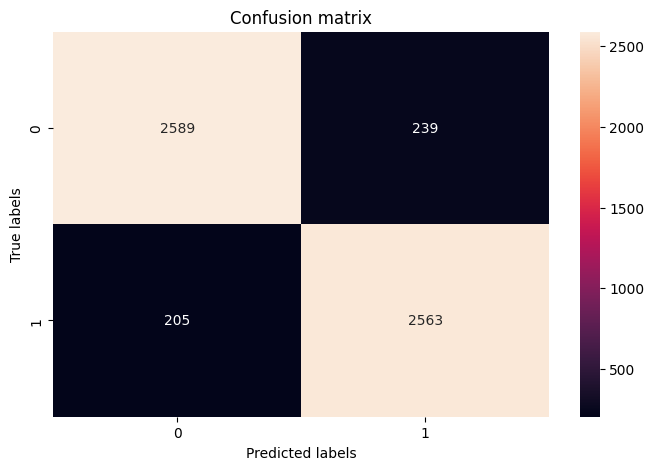

In [43]:
c_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 5))
class_names = df['label'].unique()
sns.heatmap(c_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.show()

# Model 2: Support Vector Machine

In [44]:
svm_model = SVC(probability=True, kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear', probability=True, random_state=42)

## Evaluation

In [45]:
y_train_pred = svm_model.predict(X_train_tfidf)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train F1-Score:", f1_score(y_train, y_train_pred, average='weighted'))
print(classification_report(y_train, y_train_pred))

Train Accuracy: 0.9493438186181893
Train F1-Score: 0.9493403422231906
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      9897
           1       0.95      0.94      0.95      9686

    accuracy                           0.95     19583
   macro avg       0.95      0.95      0.95     19583
weighted avg       0.95      0.95      0.95     19583



In [46]:
y_val_pred = svm_model.predict(X_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation F1-Score:", f1_score(y_val, y_val_pred, average='weighted'))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.9238741958541815
Validation F1-Score: 0.9238698094739407
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1414
           1       0.93      0.92      0.92      1384

    accuracy                           0.92      2798
   macro avg       0.92      0.92      0.92      2798
weighted avg       0.92      0.92      0.92      2798



In [47]:
y_test_pred = svm_model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1-Score:", f1_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.92012151536812
Test F1-Score: 0.9201094586489451
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2828
           1       0.93      0.91      0.92      2768

    accuracy                           0.92      5596
   macro avg       0.92      0.92      0.92      5596
weighted avg       0.92      0.92      0.92      5596



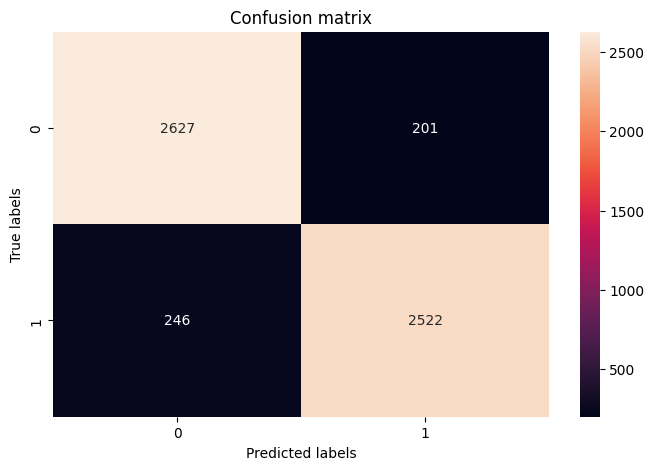

In [48]:
c_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 5))
class_names = df['label'].unique()
sns.heatmap(c_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.show()

# Model 3: Naive Bayes (MultinomialNB)

In [49]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

## Evaluation

In [50]:
y_train_pred = nb_model.predict(X_train_tfidf)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train F1-Score:", f1_score(y_train, y_train_pred, average='weighted'))
print(classification_report(y_train, y_train_pred))

Train Accuracy: 0.903079201348108
Train F1-Score: 0.9027873265854971
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      9897
           1       0.86      0.96      0.91      9686

    accuracy                           0.90     19583
   macro avg       0.91      0.90      0.90     19583
weighted avg       0.91      0.90      0.90     19583



In [51]:
y_val_pred = nb_model.predict(X_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation F1-Score:", f1_score(y_val, y_val_pred, average='weighted'))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8902787705503932
Validation F1-Score: 0.8896960138406098
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1414
           1       0.84      0.97      0.90      1384

    accuracy                           0.89      2798
   macro avg       0.90      0.89      0.89      2798
weighted avg       0.90      0.89      0.89      2798



In [52]:
y_test_pred = nb_model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1-Score:", f1_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.8906361686919227
Test F1-Score: 0.8901542257618009
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      2828
           1       0.84      0.96      0.90      2768

    accuracy                           0.89      5596
   macro avg       0.90      0.89      0.89      5596
weighted avg       0.90      0.89      0.89      5596



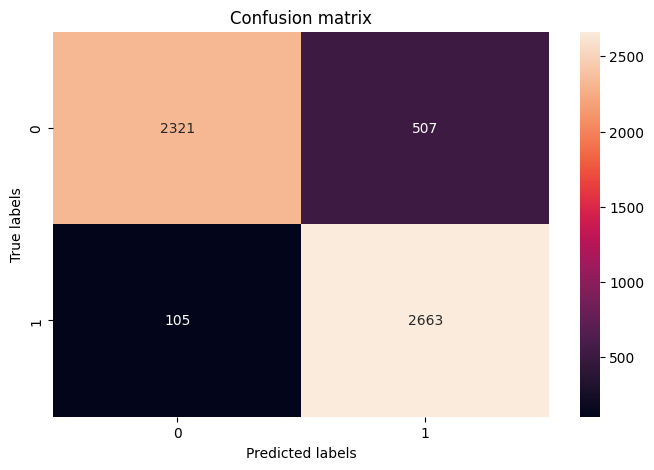

In [53]:
c_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 5))
class_names = df['label'].unique()
sns.heatmap(c_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.show()

# Model 4: XGBoost

In [54]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Evaluation

In [55]:
y_train_pred = xgb_model.predict(X_train_tfidf)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train F1-Score:", f1_score(y_train, y_train_pred, average='weighted'))
print(classification_report(y_train, y_train_pred))

Train Accuracy: 0.9483225246387172
Train F1-Score: 0.9482853424556488
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9897
           1       0.97      0.93      0.95      9686

    accuracy                           0.95     19583
   macro avg       0.95      0.95      0.95     19583
weighted avg       0.95      0.95      0.95     19583



In [56]:
y_val_pred = xgb_model.predict(X_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation F1-Score:", f1_score(y_val, y_val_pred, average='weighted'))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.9081486776268763
Validation F1-Score: 0.9081421176186475
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1414
           1       0.91      0.90      0.91      1384

    accuracy                           0.91      2798
   macro avg       0.91      0.91      0.91      2798
weighted avg       0.91      0.91      0.91      2798



In [57]:
y_test_pred = xgb_model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1-Score:", f1_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.9049320943531094
Test F1-Score: 0.9049006973928923
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2828
           1       0.92      0.89      0.90      2768

    accuracy                           0.90      5596
   macro avg       0.91      0.90      0.90      5596
weighted avg       0.91      0.90      0.90      5596



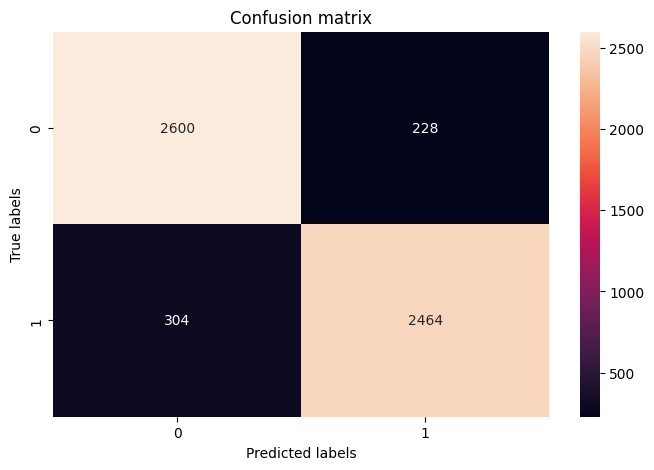

In [58]:
c_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 5))
class_names = df['label'].unique()
sns.heatmap(c_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.show()

# Model 5: Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Evaluation

In [61]:
y_train_pred = lr_model.predict(X_train_tfidf)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train F1-Score:", f1_score(y_train, y_train_pred, average='weighted'))
print(classification_report(y_train, y_train_pred))

Train Accuracy: 0.936373385078895
Train F1-Score: 0.9363593325748882
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      9897
           1       0.95      0.93      0.93      9686

    accuracy                           0.94     19583
   macro avg       0.94      0.94      0.94     19583
weighted avg       0.94      0.94      0.94     19583



In [62]:
y_val_pred = lr_model.predict(X_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation F1-Score:", f1_score(y_val, y_val_pred, average='weighted'))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.918155825589707
Validation F1-Score: 0.9181446253805131
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1414
           1       0.92      0.91      0.92      1384

    accuracy                           0.92      2798
   macro avg       0.92      0.92      0.92      2798
weighted avg       0.92      0.92      0.92      2798



In [63]:
y_test_pred = lr_model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1-Score:", f1_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.9174410293066476
Test F1-Score: 0.9174137635254065
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2828
           1       0.93      0.90      0.92      2768

    accuracy                           0.92      5596
   macro avg       0.92      0.92      0.92      5596
weighted avg       0.92      0.92      0.92      5596



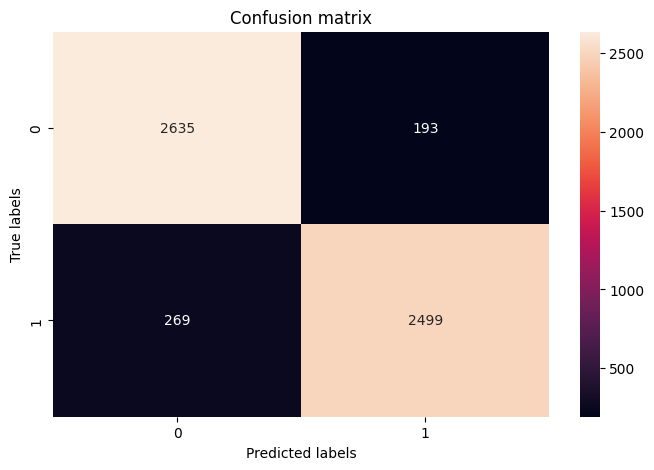

In [64]:
c_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 5))
class_names = df['label'].unique()
sns.heatmap(c_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.show()

# Model 6: Long Short-Term Memory (LSTM)

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [66]:
# Ubah bentuk TF-IDF menjadi 3D (samples, timesteps=1, features)
X_train_tfidf_3d = np.expand_dims(X_train_tfidf.toarray(), axis=1)
X_val_tfidf_3d = np.expand_dims(X_val_tfidf.toarray(), axis=1)
X_test_tfidf_3d = np.expand_dims(X_test_tfidf.toarray(), axis=1)

print("Shape X_train_tfidf_3d:", X_train_tfidf_3d.shape)

Shape X_train_tfidf_3d: (19583, 1, 5000)


In [67]:
# Parameter
n_features = X_train_tfidf_3d.shape[2]
n_classes = len(np.unique(y_train))

# Model
model = Sequential([
    LSTM(64, input_shape=(1, n_features)),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')  # Untuk klasifikasi multiclass
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │     1,296,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,296,770 (4.95 MB)

 Trainable params: 1,296,770 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Train model
history = model.fit(
    X_train_tfidf_3d, y_train,
    validation_data=(X_val_tfidf_3d, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8168 - loss: 0.4510 - val_accuracy: 0.9232 - val_loss: 0.2019
Epoch 2/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9331 - loss: 0.1771 - val_accuracy: 0.9257 - val_loss: 0.1958
Epoch 3/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9445 - loss: 0.1495 - val_accuracy: 0.9210 - val_loss: 0.2028
Epoch 4/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9542 - loss: 0.1246 - val_accuracy: 0.9199 - val_loss: 0.2158
Epoch 5/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9593 - loss: 0.1169 - val_accuracy: 0.9185 - val_loss: 0.2281
Epoch 6/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9632 - loss: 0.1095 - val_accuracy: 0.9135 - val_loss: 0.2480
Epoch 7/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9672 - loss: 0.0988 - val_accuracy: 0.9132 - val_loss: 0.2618
Epoch 8/10
612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9687 - loss: 0.0946 - val_accuracy: 0.

## Evaluation

In [70]:
y_train_pred = np.argmax(model.predict(X_train_tfidf_3d), axis=1)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train F1-Score:", f1_score(y_train, y_train_pred, average='weighted'))
print(classification_report(y_train, y_train_pred))

612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train Accuracy: 0.9770208854618802
Train F1-Score: 0.9770204194489466
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9897
           1       0.98      0.98      0.98      9686

    accuracy                           0.98     19583
   macro avg       0.98      0.98      0.98     19583
weighted avg       0.98      0.98      0.98     19583



In [71]:
y_val_pred = np.argmax(model.predict(X_val_tfidf_3d), axis=1)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation F1-Score:", f1_score(y_val, y_val_pred, average='weighted'))
print(classification_report(y_val, y_val_pred))

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Accuracy: 0.9031451036454611
Validation F1-Score: 0.9031454624606464
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1414
           1       0.90      0.90      0.90      1384

    accuracy                           0.90      2798
   macro avg       0.90      0.90      0.90      2798
weighted avg       0.90      0.90      0.90      2798



In [72]:
y_test_pred = np.argmax(model.predict(X_test_tfidf_3d), axis=1)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1-Score:", f1_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test, y_test_pred))

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.906361686919228
Test F1-Score: 0.906364186829802
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2828
           1       0.90      0.91      0.91      2768

    accuracy                           0.91      5596
   macro avg       0.91      0.91      0.91      5596
weighted avg       0.91      0.91      0.91      5596



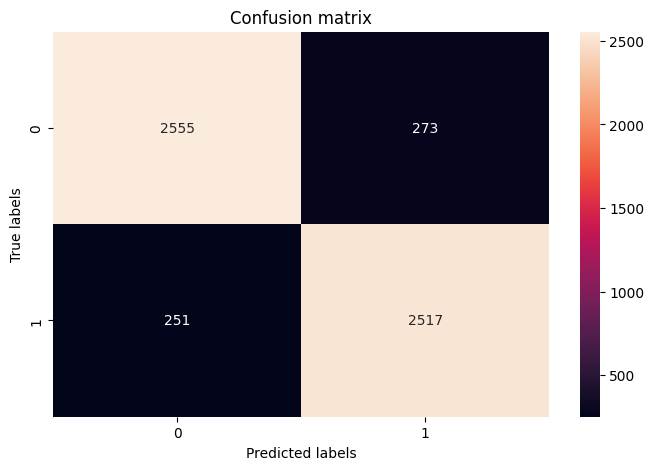

In [73]:
c_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 5))
class_names = df['label'].unique()
sns.heatmap(c_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix")
plt.show()

# Save Model

In [74]:
import pickle

In [75]:
with open('voting_model.pickle', 'wb') as file:
    pickle.dump(voting_clf, file)

In [76]:
import joblib

In [88]:
joblib.dump(voting_clf, 'voting_model.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

# Test Load dan Predict Model

In [77]:
with open('voting_model.pickle', 'rb') as file:
    loaded_model = pickle.load(file)

In [78]:
y_pred = loaded_model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.9206576125804146
F1-score: 0.9206598523920317


# Test Sentence

In [89]:
l_model = joblib.load('voting_model.joblib')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')

In [91]:
print(type(l_model))

<class 'sklearn.ensemble._voting.VotingClassifier'>


In [93]:
new_sentence = "I want to kill my self."
new_sentence_tfidf = tfidf_vectorizer.transform([new_sentence])

predicted_class = l_model.predict(new_sentence_tfidf)
print("Predicted class:", predicted_class[0])

Predicted class: 1
